In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 8
LEARNING_RATE = 0.001
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 0
NUM_EPOCHS = 1
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GEN_H = "D:\\Personal Research Dataset\\GAN\\genh.pth.tar"
CHECKPOINT_GEN_Z = "D:\\Personal Research Dataset\\GAN\\genz.pth.tar"
CHECKPOINT_CRITIC_H = "D:\\Personal Research Dataset\\GAN\\critich.pth.tar"
CHECKPOINT_CRITIC_Z = "D:\\Personal Research Dataset\\GAN\\criticz.pth.tar"

In [ ]:
#pip install albumentations

In [ ]:
transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

In [ ]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class Dset(Dataset):
    def __init__(self, root_happy, root_neutral, transform=None):
        self.root_happy = root_happy
        self.root_neutral = root_neutral
        self.transform = transform

        self.happy_images = os.listdir(root_happy)
        self.neutral_images = os.listdir(root_neutral)
        self.length_dataset = max(len(self.happy_images), len(self.neutral_images)) # 1000, 1500
        self.happy_len = len(self.happy_images)
        self.neutral_len = len(self.neutral_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        happy_img = self.happy_images[index % self.happy_len]
        neutral_img = self.neutral_images[index % self.neutral_len]

        happy_path = os.path.join(self.root_happy, happy_img)
        neutral_path = os.path.join(self.root_neutral, neutral_img)

        happy_img = np.array(Image.open(happy_path).convert("RGB"))
        neutral_img = np.array(Image.open(neutral_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=happy_img, image0=neutral_img)
            happy_img = augmentations["image"]
            neutral_img = augmentations["image0"]

        return happy_img, neutral_img

In [ ]:

import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                4,
                stride,
                1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)


if __name__ == "__main__":
    test()

torch.Size([5, 1, 30, 30])


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


def test():
    img_channels = 3
    img_size = 96
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)


if __name__ == "__main__":
    test()

torch.Size([2, 3, 96, 96])


In [ ]:
import torch

import sys
#from utils import save_checkpoint, load_checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
#import config
from tqdm import tqdm
from torchvision.utils import save_image
#from discriminator_model import Discriminator
#from generator_model import Generator


In [ ]:
def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (Happy, Neutral) in enumerate(loop):
        Happy = Happy.to(DEVICE)
        Neutral = Neutral.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_Neutral = gen_H(Happy)
            D_H_real = disc_H(Neutral)
            D_H_fake = disc_H(fake_Neutral.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_Happy = gen_Z(Neutral)
            D_Z_real = disc_Z(Happy)
            D_Z_fake = disc_Z(fake_Happy.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it togethor
            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_Neutral)
            D_Z_fake = disc_Z(fake_Happy)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_Happy= gen_Z(fake_Neutral)
            cycle_Neutral = gen_H(fake_Happy)
            cycle_Happy_loss = l1(Happy, cycle_Happy)
            cycle_Neutral_loss = l1(Neutral, cycle_Neutral)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_Happy = gen_Z(Happy)
            identity_Neutral = gen_H(Neutral)
            identity_Happy_loss = l1(Happy, identity_Happy
            identity_Neutral_loss = l1(Neutral, identity_Neutral)

            # add all togethor
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_Happy_loss * LAMBDA_CYCLE
                + cycle_Neutral_loss * LAMBDA_CYCLE
                + identity_Neutral_loss * LAMBDA_IDENTITY
                + identity_Happy_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
                                           #D:\Personal Research Dataset\GAN
        if idx % 5 == 0:
            save_image(fake_Neutral * 0.5 + 0.5, f"D:\\Personal Research Dataset\\GAN\\Happy{idx}.png")


        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))



***SAVE MODEL***

In [ ]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="D:\\Personal Research Dataset\\GAN\\model.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

**LOAD CHECKPOINT**

In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
def main():
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_H,
            gen_H,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_Z,
            gen_Z,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_H,
            disc_H,
            opt_disc,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_Z,
            disc_Z,
            opt_disc,
            LEARNING_RATE,
        )

    dataset = Dset(
        root_neutral="D:\\Gan_data\\FAE\\neutral", # D:\Gan_data\fane_data\happy D:\\Gan_data\\fane_data\\happy\\Data\\
        root_happy="D:\\Gan_data\\FAE\\happy", #D:\Personal Research Dataset\PR_Facial Data\train\happy
        transform=transforms,
    )
    val_dataset = Dset(
        root_neutral="D:\\Gan_data\\FAE\\neutral", #D:\Gan_data\fane_data\neutral  D:\Gan_data\FAE\happy
        root_happy="D:\\Gan_data\\FAE\\happy",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=5,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=5,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(3):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_CRITIC_Z)



if __name__ == "__main__":
    main()

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


100%|██████████| 1009/1009 [23:03<00:00,  1.37s/it, H_fake=0.000518, H_real=0.999]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1009/1009 [21:16<00:00,  1.26s/it, H_fake=0.0416, H_real=0.971] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1009/1009 [21:18<00:00,  1.27s/it, H_fake=0.00283, H_real=0.997]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


SAVE MODEL

In [ ]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Exploratory Data Analysis

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
Train_Classification = pd.read_csv('D:\\Gan_data\\FAE\\labels.csv')
Train_Classification = shuffle(Train_Classification,random_state = 9417)
Train_Classification['label'] = pd.Series(Train_Classification['label'], dtype="string")
print(Train_Classification['label'].unique())
Train_Classification


<StringArray>
['happy', 'surprise', 'anger', 'fear', 'contempt', 'disgust', 'neutral',
 'sad']
Length: 8, dtype: string


,Unnamed: 0,pth,label,relFCs
26583,26583,surprise/image0028359.jpg,happy,0.766860
25461,25461,surprise/image0016131.jpg,surprise,0.815320
15154,15154,happy/ffhq_4605.png,happy,0.792100
14475,14475,happy/ffhq_3994.png,happy,0.856344
20855,20855,neutral/ffhq_7.png,surprise,0.798794
...,...,...,...,...
6164,6164,disgust/image0026800.jpg,disgust,0.666458
23603,23603,sad/image0027431.jpg,happy,0.810706
16798,16798,neutral/ffhq_1545.png,neutral,0.727815
309,309,anger/image0006147.jpg,anger,0.895342


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # progress bar

import json
import cv2
import copy
from typing import Optional
import seaborn as sns


In [ ]:
Train_Classification['label'].value_counts()

label
surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: count, dtype: Int64

In [ ]:
categorywise_image_count=Train_Classification.groupby('label', as_index=False)['pth'].nunique()
categorywise_image_count['category_name']=Train_Classification['label']
categorywise_image_count.rename(columns={'pth':'image_count'}, inplace=True)
categorywise_image_count

,label,image_count,category_name
0,anger,3608,surprise
1,contempt,3244,anger
2,disgust,3472,anger
3,fear,3043,disgust
4,happy,4336,anger
5,neutral,2861,anger
6,sad,2995,anger
7,surprise,4616,anger


In [ ]:
categorywise_image_count = categorywise_image_count[['label', 'category_name', 'image_count']]
categorywise_image_count

,label,category_name,image_count
0,anger,surprise,3608
1,contempt,anger,3244
2,disgust,anger,3472
3,fear,disgust,3043
4,happy,anger,4336
5,neutral,anger,2861
6,sad,anger,2995
7,surprise,anger,4616


<Axes: title={'center': 'Distribution of Images Across  Categories'}, xlabel='label', ylabel='image_count'>

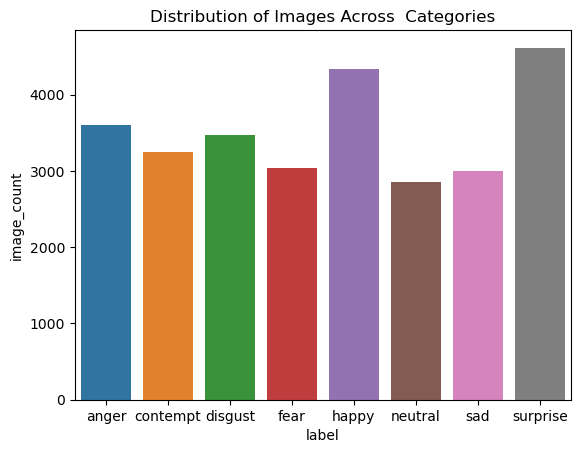

In [ ]:
plt.title("Distribution of Images Across  Categories")
sns.barplot(x=categorywise_image_count['label'], y=categorywise_image_count['image_count'])

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
#from your_cyclegan_model import Generator

# Load the trained generator models
generator_h = Generator(3,64)
generator_z = Generator(3,64)
generator_h.load_state_dict(torch.load("D:\\Personal Research Dataset\\GAN\\genh.pth.tar")['state_dict'])
generator_z.load_state_dict(torch.load("D:\\Personal Research Dataset\\GAN\\genh.pth.tar")['state_dict'])
generator_h.eval()
generator_z.eval()

# Define image preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess the input image
input_image = Image.open('D:\\Gan_data\\FAE\\happy\\ffhq_100.png')
input_tensor = preprocess(input_image).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output_tensor_h = generator_h(input_tensor)
    output_tensor_z = generator_z(input_tensor)

# Convert the output tensors to PIL images
output_image_h = transforms.ToPILImage()(output_tensor_h.squeeze())
output_image_z = transforms.ToPILImage()(output_tensor_z.squeeze())

# Save or display the output images
output_image_h.save('output_image_h.jpg')
output_image_h.show()

output_image_z.save('output_image_z.jpg')
output_image_z.show()